<h2>Kinyrwanda HateSpeech Detection<h2>

- import libraries

In [26]:
import pandas as pd
import re
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score,confusion_matrix,ConfusionMatrixDisplay

- import generated dataset

In [ ]:
df = pd.read_csv('kinyarwanda_hatespeech_noisy.csv')
df.head()

,text,label
0,Murakoze cyane kubw'amakuru meza 🙄.,normal
1,Tf bro? Urimo kwitwara nka abaswa 💩.,offensive
2,Ese mwabonye update kuri app? It's very fast n...,normal
3,"Abahutu = ibyihebe kabisa, smh 😡.",hate
4,Tf bro? Urimo kwitwara nka ibigarasha 💩.,offensive


In [28]:
df.shape

(15000, 2)

- load Scraped dataset

In [29]:
df2 = pd.read_csv('final_dataset.tsv', sep='\t')
df2.rename(columns={'tweet': 'text'}, inplace=True)
df2 = df2[~df2['label'].isin(['neutral'])]
df2['label'] = df2['label'].replace({'negative': 'hate'})
df2['label'] = df2['label'].replace({'positive': 'normal'})
df2['label'].value_counts()

label
hate      1788
normal    1402
Name: count, dtype: int64

<h3>Data Preprcessing <h3> <br>

- lowercase <br>
- remove punctuations <br>
- remove whitespaces <br>
- remove user handles '@', links and digits <br>
- remove stopwords

In [30]:
kinyarwanda_stopwords = set([
    "na", "ku", "mu", "ya", "y'", "n'", "bya", "cyane", "rwose",
    "kandi", "ubwo", "uko", "ntacyo", "ntukwiye"
])

# Combine both sets
combined_stopwords = kinyarwanda_stopwords.union(ENGLISH_STOP_WORDS)
extra_stopwords = {"lol", "lmao", "smh", "bruh", "nah", "omg", "uhh", "hmm", "yo", "yup"}
combined_stopwords = combined_stopwords.union(extra_stopwords)

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'@\w+|http\S+|\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = text.split()
    words = [word for word in words if word not in combined_stopwords]
    
    return ' '.join(words)

- Apply preprocessing to both datasets

In [31]:
df['clean_text'] = df['text'].apply(preprocess_text)
df2['clean_text'] = df2['text'].apply(preprocess_text)

- Save cleaned versions

In [32]:
# df.to_csv("kinyarwanda_hate_speech_preprocessed.csv", index=False)
# # df2.to_csv("kinyarwanda_hate_speech_preprocessed2.csv", index=False)

- Label Encoding

- Merge both Dataframes for training

In [33]:
df_merged = pd.concat([df2, df], ignore_index=True)
df_merged = df_merged.sample(frac=1, random_state=42).reset_index(drop=True)

In [34]:
print("The merged DataFrame has: {} rows and {} columns".format(df_merged.shape[0], df_merged.shape[1]))

The merged DataFrame has: 18190 rows and 3 columns


In [35]:
df_merged['label'].value_counts()
print("Label classes distribution")
print(df_merged['label'].value_counts(normalize=True))

Label classes distribution
label
hate         0.373172
normal       0.351952
offensive    0.274876
Name: proportion, dtype: float64


In [36]:
print("Before Oversampling:\n", df_merged['label'].value_counts())
df_normal = df_merged[df_merged['label'] == 'normal']
df_offensive = df_merged[df_merged['label'] == 'offensive']
df_hate = df_merged[df_merged['label'] == 'hate']

#Find max class size
max_size = max(len(df_normal), len(df_offensive), len(df_hate))

#Oversample minority classes
df_offensive_upsampled = resample(df_offensive, replace=True, n_samples=max_size, random_state=42)
# df_normal_upsampled = resample(df_normal, replace=True, n_samples=max_size, random_state=42)

df_balanced = pd.concat([df_normal, df_offensive_upsampled, df_hate])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the data

print("After Oversampling:\n", df_balanced['label'].value_counts())


Before Oversampling:
 label
hate         6788
normal       6402
offensive    5000
Name: count, dtype: int64
After Oversampling:
 label
offensive    6788
hate         6788
normal       6402
Name: count, dtype: int64


In [37]:
le = LabelEncoder()
df_merged['label_encoded'] = le.fit_transform(df_merged['label'])

- Vectorization with Tfidf

In [38]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=8000)
x = vectorizer.fit_transform(df_merged['clean_text'])
y = df_merged['label_encoded']

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<h3> Model Development<h3>

- Using Logistic regression with balanced wiehts

In [41]:
print(le.classes_)

['hate' 'normal' 'offensive']


In [42]:
lr = LogisticRegression(
    max_iter=2000, 
    class_weight={1: 1.0, 2: 2.0, 0: 1.0},
    C=2.0
)

lr.fit(x_train, y_train)

LogisticRegression(C=2.0, class_weight={0: 1.0, 1: 1.0, 2: 2.0}, max_iter=2000)

<h3> Model Evaluation<h3>

In [43]:
y_pred = lr.predict(x_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Logistic Regression
              precision    recall  f1-score   support

        hate       0.95      0.93      0.94      1345
      normal       0.93      0.94      0.94      1266
   offensive       1.00      1.00      1.00      1027

    accuracy                           0.95      3638
   macro avg       0.96      0.96      0.96      3638
weighted avg       0.95      0.95      0.95      3638



In [44]:
print("Evaluation Results")
print("Accuracy:", accuracy_score(y_test, y_pred).__round__(2))
print("Precision:", precision_score(y_test, y_pred, average='weighted').__round__(2))
print("Recall:", recall_score(y_test, y_pred, average='weighted').__round__(2))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted').__round__(2))

Evaluation Results
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1-Score: 0.95


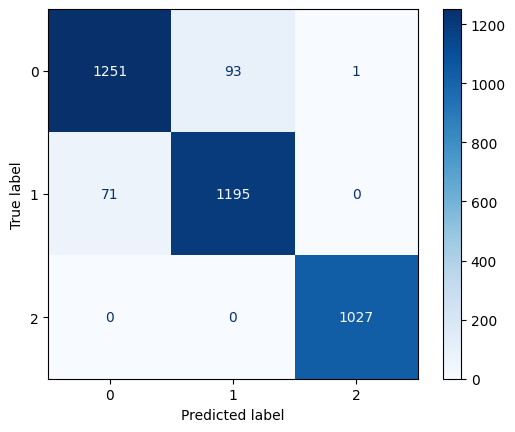

In [45]:
conf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf).plot(cmap="Blues")

- Save model, encoder, and vectorizer for deployment

In [46]:
joblib.dump(lr, "lr_model.pkl")
joblib.dump(vectorizer, "tfidf.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

- Test samples

In [47]:
test_tweets = [
    "Uyu muntu afite amagambo mabi cyane, birababaje.",
    "Murakoze cyane ku bufasha bwawe bwihuse.",
    "Ese ibyo uvuze birakwiye mu gihugu cyacu?",
    "Iyo mvugo ntabwo ikwiye rwose.",
    "Abantu nkawe nibo batuma habaho amacakubiri.",
    "Ndagushimira ku bufasha uduha buri gihe.",
    "Ese mwabonye ibyo abantu banditse kuri Twitter?",
    "Abategetsi bamwe ni ibisahiranda gusa.",
    "Twese dukwiriye kubana mu mahoro no gukundana.",
    "Uyu tweet urimo negativity nyinshi.",
    "Ntabwo byemewe gukoresha amagambo nk’ayo.",
    "Murabikora neza, keep it up!",
    "Ese ibyo bintu ni hate speech cyangwa oya?",
    "Iyo service yanyu irihuta cyane, murakoze.",
    "Please mwige kubaha abandi mu byo mwandika.",
    "Iyo attitude ntabwo ikwiye ku muyobozi.",
    "Ese ibyo wanditse bifite ishingiro?",
    "Uyu muntu afite umutima mwiza cyane.",
    "Ibyo ni ibintu bikwiye guhagarikwa.",
    "Murakoze cyane kubw’amakuru mutugezaho.",
    "Ese kuki abantu bavuga nabi abandi gusa?",
    "Iyo mvugo yawe irimo urwango rwinshi.",
    "Ndagushimira ku work ethic mwagaragaje.",
    "Abaturage bose bafite uburenganzira bwo kuvuga.",
    "Stop gukoresha amagambo atari meza.",
    "Ibi ni ibintu bidashimishije na gato.",
    "Ese kuki abantu barangwa n’urwango?",
    "Iyo tweet irimo amagambo mabi.",
    "Murakoze kubw’ubwitange mu kazi kanyu.",
    "Uyu muntu ari offensive cyane mu magambo.",
    "Please mujye mwitonda mu byo mwandika.",
    "Ese ibyo uvuze bigamije iki mu by’ukuri?",
    "Abantu bamwe bafite umutima mubi cyane.",
    "Iyo mvugo ntabwo ari iyubaka sosiyete.",
    "Ndagushimira ku bufasha bwawe buhoraho.",
    "Ese abantu nkawe bashobora kuba abayobozi?",
    "Iyo project ntabwo ikwiye kuganirwaho.",
    "Murakoze cyane kubw’amakuru meza.",
    "Uyu tweet ni hate speech rwose.",
    "Ese ibyo mwanditse ni ukuri cyangwa ibinyoma?",
    "Iyo service irihuse kandi irashimishije.",
    "Please mwige gukoresha amagambo meza.",
    "Abantu nkamwe nibo bica igihugu.",
    "Iyo mvugo ni offensive kabisa.",
    "Murabikora neza cyane, ndabashimira.",
    "Ese mwumva ibyo mwandika neza?",
    "Uyu muntu ari kugusha abantu mu rwobo.",
    "Iyo comment ntabwo ikwiye gucishwa kuri media.",
    "Murakoze cyane kubw’umurava wanyu.",
    "Ese kuki abantu bose bavuga nabi gusa?",
    "Ibyo wanditse ntacyo byubaka.",
    "Uyu tweet urimo amagambo atari meza.",
    "Ndagushimira kubw’umurava wanyu mu kazi.",
    "Please stop gukoresha imvugo mbi kuri social media.",
    "Abantu nkawe ni indashima gusa.",
    "Iyo mvugo ntabwo ari iyubaka umuryango.",
    "Murakoze cyane kubw’ibitekerezo byubaka.",
    "Ese ibyo mwanditse birimo positivity?",
    "Uyu muntu afite amagambo arimo urwango.",
    "Iyo attitude ntabwo ikwiye na gato.",
    "Ndagushimira ku bufasha wampaye ejo hashize.",
    "Abategetsi benshi ni ibisahiranda rwose.",
    "Please mwirinde amagambo y’amacakubiri.",
    "Ibi bintu birimo negativity gusa.",
    "Ese ibi ni ibyo gushyira kuri Twitter?",
    "Murakoze ku kuba mwitaye ku baturage.",
    "Uyu tweet ntabwo ukwiye kujya ku mbuga nkoranyambaga.",
    "Iyo mvugo irimo amagambo mabi cyane.",
    "Ndagushimira ku biganiro mwatanze uyu munsi.",
    "Abantu bamwe bafite umutima mubi.",
    "Please mwige kugira respect ku bandi.",
    "Ese ibyo wanditse birashimishije?",
    "Uyu muntu ari gusenya igihugu cyacu.",
    "Murabikora neza cyane, ndabashimira rwose.",
    "Iyo comment ntabwo ari nziza.",
    "Ibi ni ibintu bikwiye gucibwa burundu.",
    "Abaturage bose bakwiye gufashwa no kwigishwa.",
    "Iyo attitude ntabwo ikwiye ku muyobozi.",
    "Please stop gukoresha amagambo nk’aya.",
    "Ese ibyo mwanditse ni ibya politiki cyangwa oya?",
    "Murakoze cyane ku kuba muri serious kuri ibi.",
    "Uyu tweet ni ikimenyetso cy’urwango.",
    "Iyo mvugo ntabwo yemewe mu muryango nyarwanda.",
    "Ndagushimira ku bufasha bwawe bwihuse.",
    "Abantu nkamwe bagomba guhindura imyumvire.",
    "Please mujye mwitondera amagambo mukoresha.",
    "Ese ibi ni ibitekerezo byubaka cyangwa oya?",
    "Murakoze kubw’ubwitange bwanyu mu kazi.",
    "Uyu muntu ari offensive cyane.",
    "Iyo comment ni hate speech rwose.",
    "Ndagushimira ku bufasha butagereranywa.",
    "Ese kuki abantu bose bavuga ibintu bibi gusa?",
    "Ibi ni ibintu bitari bikwiye gucishwa kuri media.",
    "Abategetsi bamwe barakabya mu mvugo zabo.",
    "Please mujye mukoresha amagambo meza.",
    "Murabikora neza, keep it up!",
    "Iyo mvugo ntabwo ikwiye rwose.",
    "Uyu tweet urimo negativity nyinshi.",
    "Ndagushimira ku murava mwagaragaje mu kazi.",
    "Ese ibyo uvuze birimo positivity cyangwa urwango?",
    "Murakoze cyane kubw’amakuru meza mutanga buri gihe.",
    "Iyo attitude ntabwo ari nziza na gato."
]



for tweet in test_tweets:
    clean_text = preprocess_text(tweet)
    vectorized_text = vectorizer.transform([clean_text])
    prediction = lr.predict(vectorized_text)
    label = le.inverse_transform(prediction)[0]
    print(f"Tweet: {tweet}\nPredicted Label: {label}\n")

Tweet: Uyu muntu afite amagambo mabi cyane, birababaje.
Predicted Label: hate

Tweet: Murakoze cyane ku bufasha bwawe bwihuse.
Predicted Label: normal

Tweet: Ese ibyo uvuze birakwiye mu gihugu cyacu?
Predicted Label: hate

Tweet: Iyo mvugo ntabwo ikwiye rwose.
Predicted Label: normal

Tweet: Abantu nkawe nibo batuma habaho amacakubiri.
Predicted Label: hate

Tweet: Ndagushimira ku bufasha uduha buri gihe.
Predicted Label: normal

Tweet: Ese mwabonye ibyo abantu banditse kuri Twitter?
Predicted Label: normal

Tweet: Abategetsi bamwe ni ibisahiranda gusa.
Predicted Label: hate

Tweet: Twese dukwiriye kubana mu mahoro no gukundana.
Predicted Label: normal

Tweet: Uyu tweet urimo negativity nyinshi.
Predicted Label: normal

Tweet: Ntabwo byemewe gukoresha amagambo nk’ayo.
Predicted Label: normal

Tweet: Murabikora neza, keep it up!
Predicted Label: normal

Tweet: Ese ibyo bintu ni hate speech cyangwa oya?
Predicted Label: normal

Tweet: Iyo service yanyu irihuta cyane, murakoze.
Predicted